### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [2]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
%env SM_FRAMEWORK=tf.keras
#!pip install -U albumentations>=0.3.0 --user 
#!pip install -U --pre segmentation-models --user

env: SM_FRAMEWORK=tf.keras


# Loading dataset

In [3]:
import os

import cv2
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from segmentation_models.utils import set_trainable
import tensorflow as tf

Segmentation Models: using `tf.keras` framework.


In [4]:
DATA_DIR = r'C:\Users\Gabriel\OneDrive - Universidade de Tras-os-Montes e Alto Douro\UTAD\2020-2021\Pesquisa\Dataset\teste_masks_crop3'

In [5]:
#load the images and annotations

x_train_dir = os.path.join(DATA_DIR, 'train', 'image')
y_train_dir = os.path.join(DATA_DIR, 'train', 'mask')

x_valid_dir = os.path.join(DATA_DIR, 'validation', 'image')
y_valid_dir = os.path.join(DATA_DIR, 'validation', 'mask')

x_test_dir = os.path.join(DATA_DIR, 'test', 'image')
y_test_dir = os.path.join(DATA_DIR, 'test', 'mask')

#define the images' size 
target_size = (320, 320)

# Dataloader and utility functions 

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 'leaves']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        #modifiying to read images in png format
        self.masks_fps = [os.path.join(masks_dir, image_id.split('.')[0]+'.png') for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

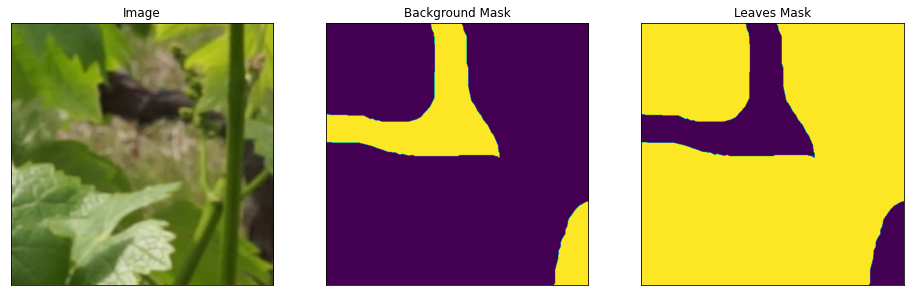

In [7]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['background', 'leaves'])

image, mask = dataset[4] # get some sample

visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
    leaves_mask=mask[..., 1].squeeze()
)



### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [8]:
import albumentations as A

In [9]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=target_size[0], min_width=target_size[1], always_apply=True, border_mode=0),
        A.RandomCrop(height=target_size[0], width=target_size[1], always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(target_size[0], target_size[1]),
        A.Resize(target_size[0], target_size[1])
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

C:\Users\Gabriel\anaconda3\envs\deeplearning\lib\site-packages\albumentations\imgaug\transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
C:\Users\Gabriel\anaconda3\envs\deeplearning\lib\site-packages\albumentations\imgaug\transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
C:\Users\Gabriel\anaconda3\envs\deeplearning\lib\site-packages\albumentations\augmentations\transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\Gabriel\anaconda3\envs\deeplearning\lib\site-packages\albumentations\imgaug\transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is depreca

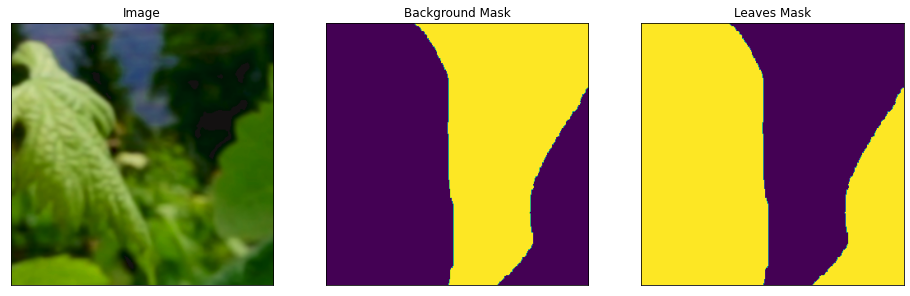

In [10]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['background', 'leaves'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
    leaves_mask=mask[..., 1].squeeze()
)

# Segmentation model training

In [11]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [12]:
BACKBONE = 'resnet101'
BATCH_SIZE = 8
CLASSES = ['leaves']
LR = 0.0001
EPOCHS = 50

preprocess_input = sm.get_preprocessing(BACKBONE)

In [13]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

with tf.device('/gpu:1'):
    #create model
    model = sm.Unet(BACKBONE, input_shape=(target_size[0],target_size[1],3), classes=n_classes, activation=activation, encoder_freeze=True)
    # define optomizer
    optim = keras.optimizers.Adam(LR)

    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)

    # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
    # total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, total_loss, metrics)

    # Dataset for train images
    train_dataset = Dataset(
        x_train_dir, 
        y_train_dir, 
        classes=CLASSES, 
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
    )

    # Dataset for validation images
    valid_dataset = Dataset(
        x_valid_dir, 
        y_valid_dir, 
        classes=CLASSES, 
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
    )

    train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

    # check shapes for errors
    assert train_dataloader[0][0].shape == (BATCH_SIZE, target_size[0], target_size[1], 3)
    assert train_dataloader[0][1].shape == (BATCH_SIZE, target_size[0], target_size[1], n_classes)

    # define callbacks for learning rate scheduling and best checkpoints saving
    callbacks = [
        keras.callbacks.ModelCheckpoint('best_model.h5', save_weights_only=True, save_best_only=True, monitor = 'val_iou_score',mode='max',verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', factor=0.95, patience=2, verbose=1, mode='max', cooldown=1, min_lr=0.000001),
    ]

    # train model
    history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=EPOCHS, 
        callbacks=callbacks, 
        validation_data=valid_dataloader, 
        validation_steps=len(valid_dataloader),
    )

    #retrain now the entire model
    set_trainable(model,recompile=False)
    #decrase the LR 
    optim = keras.optimizers.Adam(LR/100.0)

    #recompile the model
    model.compile(optim, total_loss, metrics)

    #retrain
    history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=EPOCHS, 
        callbacks=callbacks, 
        validation_data=valid_dataloader, 
        validation_steps=len(valid_dataloader),
    )


171171840/171164896 [==============================] - 3s 0us/step


C:\Users\Gabriel\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
662/662 [==============================] - 693s 1s/step - loss: 0.2150 - iou_score: 0.8643 - f1-score: 0.9232 - val_loss: 0.1715 - val_iou_score: 0.8961 - val_f1-score: 0.9383

Epoch 00001: val_iou_score improved from -inf to 0.89608, saving model to best_model.h5
Epoch 2/50
662/662 [==============================] - 668s 1s/step - loss: 0.1833 - iou_score: 0.8829 - f1-score: 0.9341 - val_loss: 0.1713 - val_iou_score: 0.8714 - val_f1-score: 0.9222

Epoch 00002: val_iou_score did not improve from 0.89608
Epoch 3/50
662/662 [==============================] - 668s 1s/step - loss: 0.1725 - iou_score: 0.8865 - f1-score: 0.9364 - val_loss: 0.1496 - val_iou_score: 0.8860 - val_f1-score: 0.9306

Epoch 00003: val_iou_score did not improve from 0.89608

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.499999760009814e-05.
Epoch 4/50
662/662 [==============================] - 668s 1s/step - loss: 0.1602 - iou_score: 0.8926 - f1-score: 0.9402 - val_loss: 0.1728 - val_iou_score

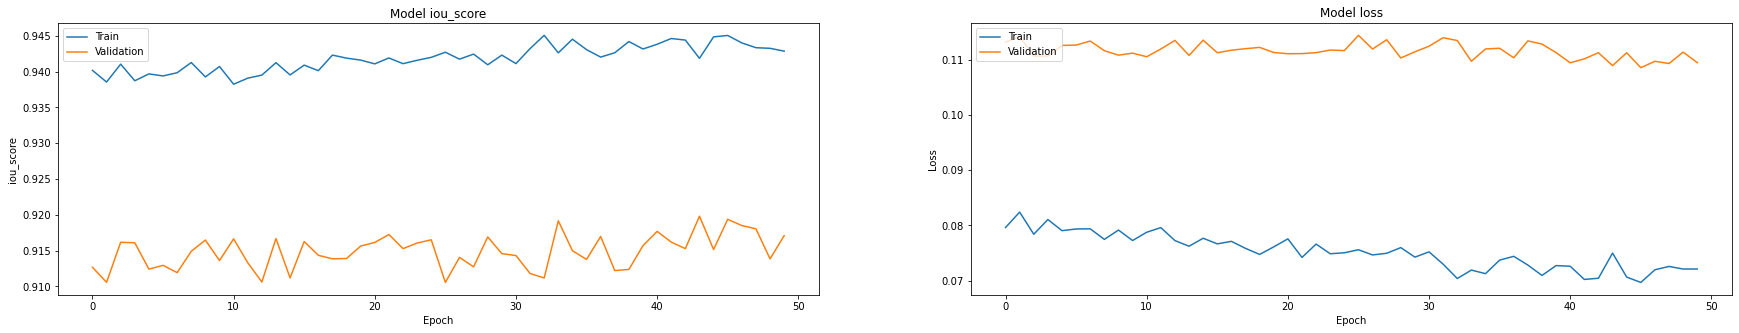

In [14]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model Evaluation

In [15]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [16]:
# load best weights
model.load_weights('best_model.h5') 

In [17]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

C:\Users\Gabriel\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss: 0.089842
mean iou_score: 0.94096
mean f1-score: 0.96674


# Visualization of results on test dataset

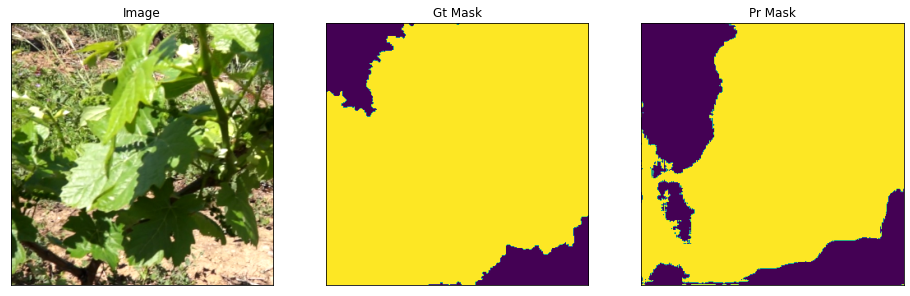

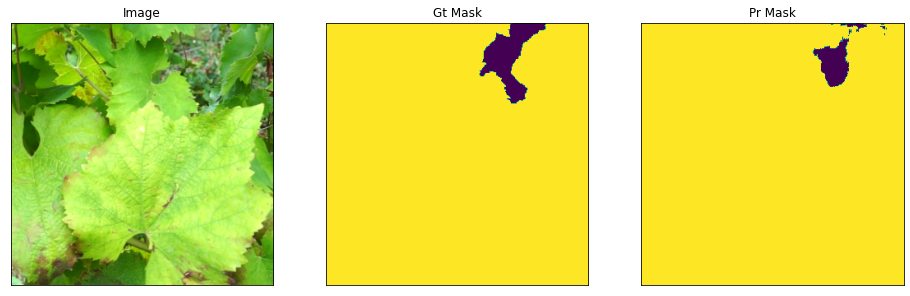

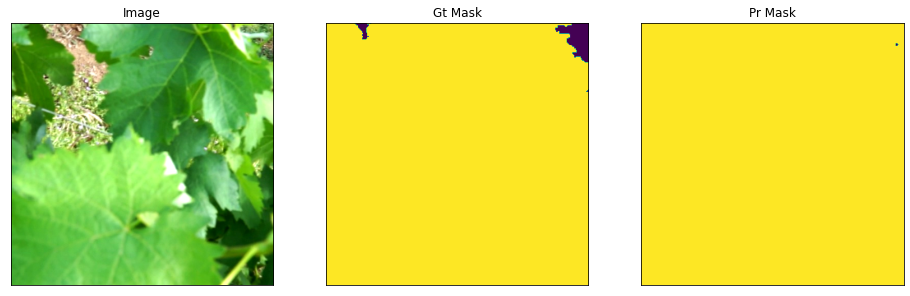

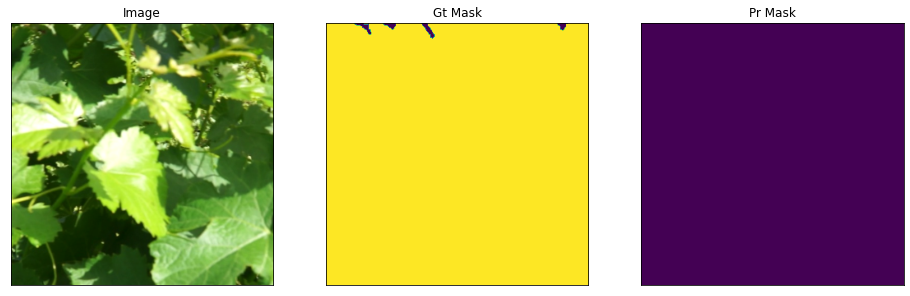

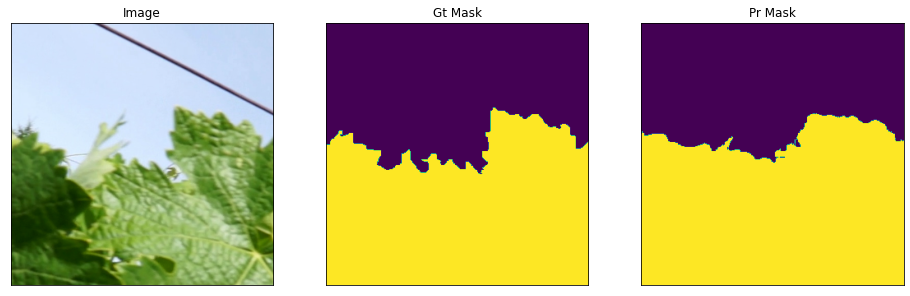

In [18]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )